#Тематическая модель на данных Last.fm

###Данные

Данные Last.fm брались <a href=http:/www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/lastfm-360K.html> отсюда</a>. Они содержат плейлисты 360 тысяч пользователей с указанием сколько раз каждый юзер слушал музыканта. Эти плейлисты рассматривались как документы в тематической модели, и выделенные темы образовывали различные музыкальные жанры (названия которых я оставлю подобрать читателю).

###Процесс

Подключаем все необходимые библиотеки.

In [1]:
from lastfm_util import *
import matplotlib.pyplot as plt

import artm.artm_model
from artm.artm_model import *

%matplotlib inline

plays_file = 'usersha1-artmbid-artname-plays.tsv' #Название файла с данными

Теперь надо распарсить коллекцию и подать ее библиотеке. Я использовал свой парсер и создавал вручную батчи в нужном формате.

In [2]:
batch_path = create_batches(users_to_handle = 100000, users_in_batch = 1000) 
#Мы обрабатываем только первые 100 тысяч записей и строим батчи по 1000 штук юзеров в каждом

Следующий шаг - настоить и запустить bigartm.

Создаем названия главных и фоновых тем, потом настраиваем регуляризаторы и счетчики.

In [3]:
all_topics, objective_topics, background_topics = create_topic_names(200, 5)

model = ArtmModel(topic_names=all_topics)
model.num_processors = 4

#Счетчики
model.scores.add(SparsityPhiScore(name='ObjectiveSparsityPhiScore', topic_names=objective_topics))
model.scores.add(SparsityThetaScore(name='ObjectiveSparsityThetaScore', topic_names=objective_topics))
model.scores.add(PerplexityScore(name='PerplexityScore'))
model.scores.add(TopTokensScore(name='TopTokensScore', num_tokens=5))
model.scores.add(TopTokensScore(name='TopTokensScoreExtended', num_tokens=20))

#Регуляризаторы
model.regularizers.add(SmoothSparsePhiRegularizer(name='ObjectiveSparsePhi',
                                                  topic_names=objective_topics, tau=-0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='ObjectiveSparseTheta',
                                                    topic_names=objective_topics, tau=-2.0))
model.regularizers.add(SmoothSparsePhiRegularizer(name='BackgroundSparsePhi',
                                                  topic_names=background_topics, tau=0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='BackgroundSparseTheta',
                                                    topic_names=background_topics, tau=2.0))
model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi',
                                                  topic_names=objective_topics, tau=100000.0))

model.initialize(data_path=batch_path)

Запускаем!

In [4]:
model.fit_offline(data_path=batch_path, num_collection_passes=15)

###Результаты

Теперь уже можно порисовать графики и вывести жанры. 

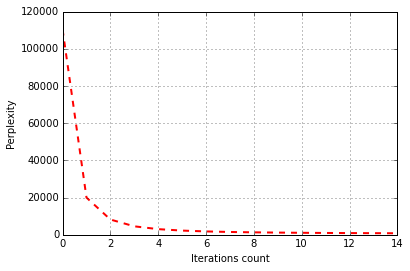

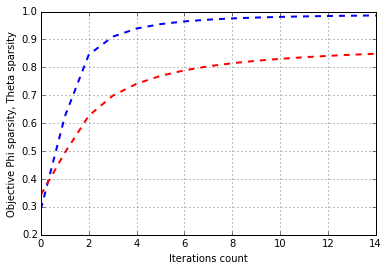

In [5]:
plt.plot(range(model.num_phi_updates), model.scores_info['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

plt.plot(range(model.num_phi_updates), model.scores_info['ObjectiveSparsityPhiScore'].value, 'b--',
         range(model.num_phi_updates), model.scores_info['ObjectiveSparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Objective Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

In [6]:
print_genres(model, objective_topics, background_topics)

Genres
objective topic 0:  [u'metallica', u'black sabbath', u'mot\xf6rhead', u'deep purple', u'black label society']
objective topic 1:  [u'dropkick murphys', u'flogging molly', u'rancid', u'madness', u'the specials']
objective topic 2:  [u'tocotronic', u'kettcar', u'tomte', u'the notwist', u'rosenstolz']
objective topic 3:  [u'rush', u'the sisters of mercy', u'siouxsie and the banshees', u'bauhaus', u'steely dan']
objective topic 4:  [u'\ub3d9\ubc29\uc2e0\uae30', u'big bang', u'super junior', u'kat-tun', u'epik high']
objective topic 5:  [u'die \xc4rzte', u'b\xf6hse onkelz', u'die toten hosen', u'farin urlaub', u'broilers']
objective topic 6:  [u'cannibal corpse', u'behemoth', u'nile', u'meshuggah', u'vader']
objective topic 7:  [u'incubus', u'stereophonics', u'311', u'our lady peace', u'ash']
objective topic 8:  [u'glenn gould', u'camel', u'os mutantes', u'emerson, lake & palmer', u'seu jorge']
objective topic 9:  [u'bad religion', u'nofx', u'millencolin', u'anti-flag', u'pennywise']

Дальше мы можем по этой тематической модели искать похожих артистов и давать рекомендации пользователям.

Например, найдем похожих артистов для Metallica, Green day и Beatles. 

In [7]:
print "Mettalica"
for musician in find_similar_musicians(model, "metallica", 5, objective_topics):
    print musician[0], musician[1]
print "Green day"
for musician in find_similar_musicians(model, "green day", 5, objective_topics):
    print musician[0], musician[1]
print "Beatles"
for musician in find_similar_musicians(model, "the beatles", 5, objective_topics):
    print musician[0], musician[1]

Mettalica
0.0596895914539 black sabbath
0.0370497202255 motörhead
0.0208851218806 deep purple
0.0208783883819 black label society
0.0169997033966 pantera
Green day
0.14385525151 linkin park
0.0191671629789 nickelback
0.00953302687415 fort minor
0.00753056790779 eminem
0.00229328834612 jay-z and linkin park
Beatles
0.0298802760885 the beach boys
0.0270847116987 john lennon
0.0143877274924 paul mccartney
0.0102277409521 george harrison
0.00648181141148 weezer


In [9]:
def print_user_info(user_id, top_musicians_count):
    for match in sorted([(match[1], match[0]) for match in users[user_id].items()], reverse=True)[:top_musicians_count]:
        print match[0], match[1]
    
def recommend_musicians(model, user_id, top_musicians_count, objective_topics):
    top_matches = {}
    
    user_topic = users[user_id]

    for topic in objective_topics:
        topic_musicians = model.scores_info['TopTokensScoreExtended'].last_topic_info[topic].tokens
        topic_weights = model.scores_info['TopTokensScoreExtended'].last_topic_info[topic].weights
        
        user_score = 0
        for musician in topic_musicians:
            if musician in user_topic:
                user_score += user_topic[musician] * topic_weights[topic_musicians.index(musician)]
        
        for musician in topic_musicians:
            if musician not in user_topic:
                if musician in top_matches:
                    top_matches[musician] += user_score * topic_weights[topic_musicians.index(musician)]
                else:
                    top_matches[musician] = user_score * topic_weights[topic_musicians.index(musician)]

    return sorted([(match[1], match[0]) for match in top_matches.items()], reverse=True)[:top_musicians_count]

user_id = "000710d4dff11af267edd2f70bf54e7678bdd729"
print "User's top musicians"
print_user_info(user_id, 5)
    
print

print "Recommendations"
for musician in recommend_musicians(model, user_id, 5, objective_topics):
    print musician[0], musician[1]


User's top musicians
0.0837137118861 radiohead
0.0588825999635 the knife
0.0555048384152 the hives
0.0298521088187 yeah yeah yeahs
0.026839510681 phoenix

Recommendations
0.00451580265449 pink floyd
0.00236852535405 the white stripes
0.00175632873202 muse
0.00151532176732 modest mouse
0.00145771811452 queens of the stone age
